# SpringSet: numerical and visual analysis

In [ ]:
import sys
sys.path.append('../')

import os
import numpy as np
import h5py
import essentia
import essentia.standard as es
from pathlib import Path

import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = [10, 6]
%matplotlib inline

In [13]:
# Setting up the directories and the sample rate

DATA_DIR = Path('../data/raw/')
MODELS_DIR = Path('../models/')
RESULTS_DIR = Path('../data/features/')
PLOTS_DIR = Path('../docs/plots/')

sample_rate = 16000
spring_dir = DATA_DIR / 'springset/' 

## Read the data

In [14]:
# List and read the files in the dataset folder

data_dict = {}

for file in os.listdir(spring_dir):
    if file.endswith(('.h5')):
        file_path = os.path.join(spring_dir, file)
        with h5py.File(os.path.join(spring_dir, file), 'r') as f_handler:
            key = list(f_handler.keys())[0]
            data = f_handler[key]
            print(f"File: {file}")
            print(f"Keys: {key}")
            if len(data.attrs) > 0:
                print("Metadata attributes found:")
            for attr_name, attr_value in data.attrs.items():
                print(f"{attr_name}: {attr_value}")
            else:
                print("No metadata attributes found.")
            
            print(f"Type of ['{key}']: {type(data[:])}")
            print(f"Data shape: {data.shape}")
            print(f"Data type: {data.dtype}")
    
            data_dict[key] = data[:]  

            print("")

File: wet_val_test.h5
Keys: Yvalidation_0
No metadata attributes found.
Type of ['Yvalidation_0']: <class 'numpy.ndarray'>
Data shape: (64, 32000, 1)
Data type: float64

File: wet_train.h5
Keys: Ytrain_0
No metadata attributes found.
Type of ['Ytrain_0']: <class 'numpy.ndarray'>
Data shape: (1122, 32000, 1)
Data type: float64

File: dry_train.h5
Keys: Xtrain
No metadata attributes found.
Type of ['Xtrain']: <class 'numpy.ndarray'>
Data shape: (1122, 32000, 1)
Data type: float64

File: dry_val_test.h5
Keys: Xvalidation
No metadata attributes found.
Type of ['Xvalidation']: <class 'numpy.ndarray'>
Data shape: (64, 32000, 1)
Data type: float64



***The data is organized in the following way: `(index, samples, channels)`***

No attributes have been found in the data.

In [15]:
# Load each part of the dataset into a variable
X_train = data_dict['Xtrain']
Y_train = data_dict['Ytrain_0']
X_test = data_dict['Xvalidation']
Y_test = data_dict['Yvalidation_0']

# Print the shape of each part of the dataset
print('Xtrain shape:', X_train.shape)
print('Ytrain shape:', Y_train.shape)
print('Xtest shape:', X_test.shape)
print('Ytest shape:', Y_test.shape)

Xtrain shape: (1122, 32000, 1)
Ytrain shape: (1122, 32000, 1)
Xtest shape: (64, 32000, 1)
Ytest shape: (64, 32000, 1)


In [16]:
## Compute the stats of each file and the whole dataset ### FROM FILES NOT ARRAYS !!!

def compute_stats_of_file(data):
    min_val = np.min(data)
    max_val = np.max(data)
    mean_val = np.mean(data)
    std_val = np.std(data)
    return min_val, max_val, mean_val, std_val

# Iterate over each key-value pair in data_dict
for key, value in data_dict.items():
    stats = compute_stats_of_file(value)

    print(f"{key}: Min: {stats[0]:.3f}, Max: {stats[1]:.3f}, Mean: {stats[2]:.3f}, Std: {stats[3]:.3f}")

# Concatenate all arrays into a single one
all_data = np.concatenate(list(data_dict.values()))

# Compute the stats
global_stats = compute_stats_of_file(all_data)

print(f"Global: Min: {global_stats[0]:.3f}, Max: {global_stats[1]:.3f}, Mean: {global_stats[2]:.3f}, Std: {global_stats[3]:.3f}")

Yvalidation_0: Min: -1.006, Max: 1.007, Mean: -0.000, Std: 0.208


Ytrain_0: Min: -1.006, Max: 1.007, Mean: -0.000, Std: 0.196
Xtrain: Min: -1.019, Max: 1.018, Mean: -0.000, Std: 0.201
Xvalidation: Min: -1.003, Max: 1.003, Mean: -0.000, Std: 0.201
Global: Min: -1.019, Max: 1.018, Mean: -0.000, Std: 0.199


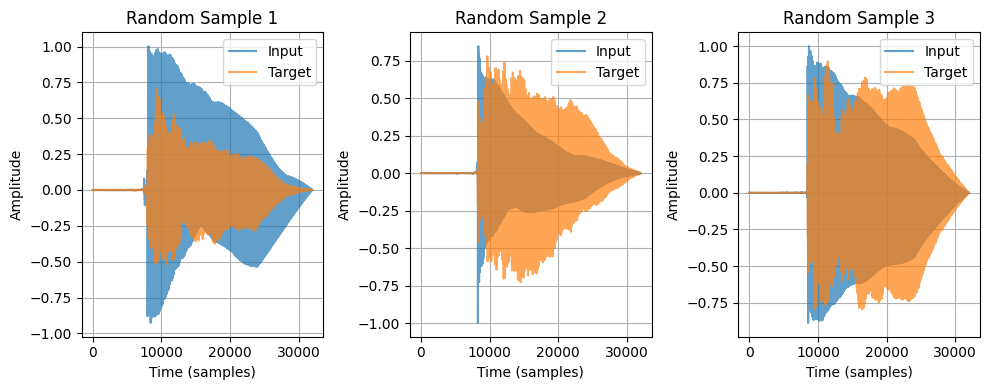

In [17]:
samples_list = [100, 600, 700]

desired_samples = []

# Loop through the indices and plot the waveform for each example
for i, sample_idx in enumerate(samples_list):
    x = X_train[sample_idx, :, 0]
    y = Y_train[sample_idx, :, 0]
    desired_samples.append((x, y))

# Plot the extracted waveforms
fig, axs = plt.subplots(nrows=1, ncols=len(desired_samples), figsize=(10, 4))
for i, (x, y) in enumerate(desired_samples):
    axs[i].plot(x.squeeze(), alpha=0.7)
    axs[i].plot(y.squeeze(), alpha=0.7)
    axs[i].set_title(f'Random Sample {i + 1}')
    axs[i].set_xlabel('Time (samples)')
    axs[i].set_ylabel('Amplitude')
    axs[i].legend(['Input', 'Target'])
    axs[i].grid(True)

plt.tight_layout()
plt.show()

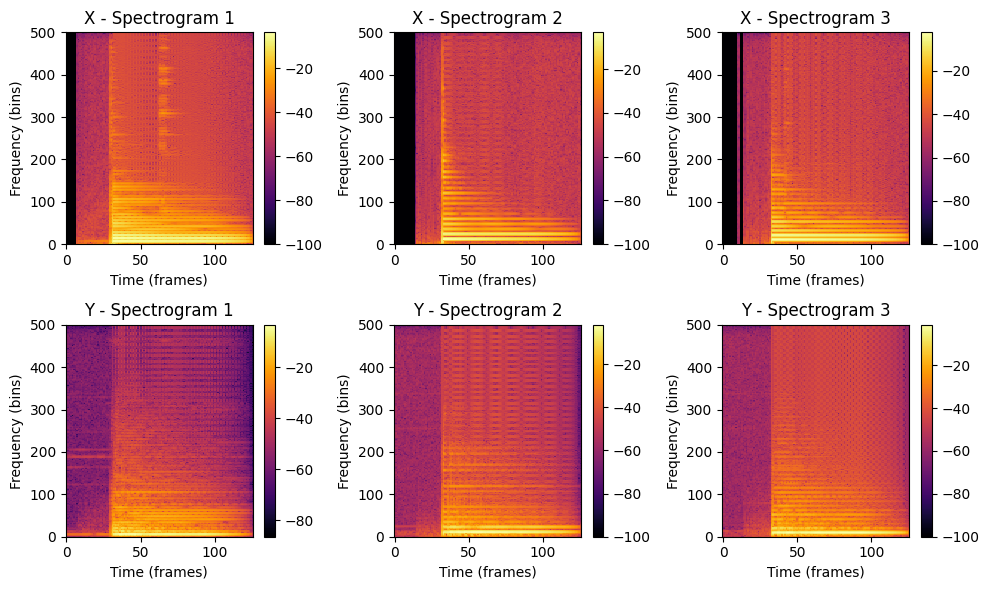

In [18]:
fig, axs = plt.subplots(nrows=2, ncols=len(desired_samples), figsize=(10, 6))

# Setting sample rate and STFT parameters
sample_rate = 16000
frameSize = 512  # STFT window size
hopSize = 256   # Overlap is frameSize - hopSize

# Setting up essentia algorithms
spectrum = es.Spectrum()
windowing = es.Windowing(type='blackmanharris62', zeroPadding=frameSize)

amp2db = es.UnaryOperator(type='lin2db', scale=1)
pool = essentia.Pool()

for idx, (x, y) in enumerate(desired_samples):
    pool.clear()
    x = x.squeeze().astype(np.float32)  # Convert data to float32
    y = y.squeeze().astype(np.float32)


    spectrograms_x = []
    spectrograms_y = []

    for frame_x, frame_y in zip(es.FrameGenerator(x, frameSize=frameSize, hopSize=hopSize),
                                es.FrameGenerator(y, frameSize=frameSize, hopSize=hopSize)):
        x_stft = spectrum(windowing(frame_x))
        y_stft = spectrum(windowing(frame_y))
        
        pool.add('spectrum_db_x', amp2db(x_stft))
        pool.add('spectrum_db_y', amp2db(y_stft))
        

    # Plotting the X spectrogram
    img_x = axs[0, idx].imshow(pool['spectrum_db_x'].T, aspect='auto', origin='lower', interpolation='none', cmap='inferno')
    axs[0, idx].set_title(f"X - Spectrogram {idx + 1}")
    axs[0, idx].set_ylabel('Frequency (bins)')
    axs[0, idx].set_xlabel('Time (frames)')
    axs[0, idx].set_ylim(0, 500)
    plt.colorbar(img_x, ax=axs[0, idx])  # Adding colorbar

    # Plotting the Y spectrogram
    img_y = axs[1, idx].imshow(pool['spectrum_db_y'].T, aspect='auto', origin='lower', interpolation='none', cmap='inferno')
    axs[1, idx].set_title(f"Y - Spectrogram {idx + 1}")
    axs[1, idx].set_ylabel('Frequency (bins)')
    axs[1, idx].set_xlabel('Time (frames)')
    axs[1, idx].set_ylim(0, 500)
    plt.colorbar(img_y, ax=axs[1, idx])

plt.tight_layout()
plt.show()